In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# List of input FASTA files
input_files = ["ecolibacteria.fasta", "humanmitochondria.fasta", "plantthale.fasta", "yeastfungai.fasta"]

# Initialize an empty sequence
combined_sequence = Seq("")

# Iterate through each FASTA file and concatenate sequences
for file in input_files:
    for record in SeqIO.parse(file, "fasta"):
        combined_sequence += record.seq

# Create a SeqRecord for the combined sequence
combined_record = SeqRecord(combined_sequence, id="combined_seq", description="Combined sequence from multiple FASTA files")

# Write the combined sequence to a new FASTA file
output_file = "combined_sequence.fasta"
SeqIO.write(combined_record, output_file, "fasta")

print(f"Combined sequence has been written to {output_file}")


In [ ]:
from IPython.display import FileLink

# Provide the path to the combined sequence file
output_file = "combined_sequence.fasta"

# Create a downloadable link
display(FileLink(output_file))


In [ ]:
import shutil

# Specify the destination path
destination_path = "/desired/path/combined_sequence.fasta"

# Copy the file
shutil.copy(output_file, destination_path)

print(f"Combined sequence file copied to {destination_path}")


In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras imbalanced-learn gensim optuna transformers biopython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.0 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez, SeqIO

# Set your email here to identify yourself to NCBI
Entrez.email = "gangonayshiva@gmail.com"

def search_ncbi(term, db="nucleotide", retmax=12):
    """
    Search NCBI for sequences matching the given term.

    Parameters:
    term (str): The search term.
    db (str): The NCBI database to search.
    retmax (int): The maximum number of records to retrieve.

    Returns:
    list: A list of accession IDs.
    """
    handle = Entrez.esearch(db=db, term=term, retmax=retmax)
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]

def fetch_sequence(accession_id):
    """
    Fetch a sequence from NCBI using the given accession ID.

    Parameters:
    accession_id (str): The accession ID of the sequence to fetch.

    Returns:
    str: The sequence in FASTA format.
    """
    handle = Entrez.efetch(db="nucleotide", id=accession_id, rettype="fasta", retmode="text")
    sequence_data = handle.read()
    handle.close()
    return sequence_data

# Define search terms for different categories
search_terms = {
    "plants": "txid33090[Organism]",   # NCBI taxonomy ID for plants
    "fungi": "txid4751[Organism]",     # NCBI taxonomy ID for fungi
    "humans": "txid9606[Organism]",    # NCBI taxonomy ID for humans
    "bacteria": "txid2[Organism]"      # NCBI taxonomy ID for bacteria
}

# Fetch and save sequences for each category
for category, term in search_terms.items():
    accession_ids = search_ncbi(term, retmax=5)  # Adjust retmax as needed
    for accession_id in accession_ids:
        sequence = fetch_sequence(accession_id)
        file_name = f"{category}_{accession_id}.fasta"
        with open(file_name, "w") as file:
            file.write(sequence)
        print(f"Saved sequence {file_name}")

        # Read and print the first 100 characters of the saved sequence
        with open(file_name, "r") as file:
            fasta_content = file.read()
            print(f"{file_name}:\n{fasta_content[:100]}...\n")

print("Sequences have been fetched, saved, and printed.")

Saved sequence plants_2746386210.fasta
plants_2746386210.fasta:
>OZ076310.1 Eucalyptus dalrympleana XLPT gene for Xylan galactopyranosyltransferase
CTCTCTCTCTCTCTCT...

Saved sequence plants_2746386208.fasta
plants_2746386208.fasta:
>OZ076309.1 Eucalyptus dalrympleana XAPT gene for Xylan arabinopyranosyltransferase
GGGAAATGATGCTGAG...

Saved sequence plants_2746290337.fasta
plants_2746290337.fasta:
>AP029598.1 Prunus speciosa IZO01 mitochondrial DNA, complete genome
ACGCCTTGATAACTGAGTTTTTTTATTGTAT...

Saved sequence plants_2746290249.fasta
plants_2746290249.fasta:
>AP029597.1 Prunus speciosa IZO01 chloroplast DNA, complete genome
TGGGCGAACGACGGGAATTGAACCCGCGCATGG...

Saved sequence plants_2746287159.fasta
plants_2746287159.fasta:
>AP029596.1 Prunus speciosa IZO01 DNA, chromosome 8, sequence
CCTAAACCCTAAACCCTAAACCCTAAACCCTAAACCCT...

Saved sequence fungi_2746388330.fasta
fungi_2746388330.fasta:

...

Saved sequence fungi_2746299067.fasta
fungi_2746299067.fasta:
>LC819004.1 Rhizopus micr

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for the "plants" category
plant_paths = [
    '/content/plants_2745858084.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2745858085.fasta',
    '/content/plants_2745858086.fasta',
    '/content/plants_2745858087.fasta',
    '/content/plants_2745858088.fasta'
]

# Load sequences from all plant FASTA files
plant_sequences = []
for path in plant_paths:
    plant_sequences.extend(load_fasta(path))

# Define sample sizes (nucleotides)
total_sample_size = 100000
segment_length = 1000

# Sample sequences
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': sampled_plant_sequences,
    'label': ['plant'] * len(sampled_plant_sequences)
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 512), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Final Model Accuracy: {accuracy * 100:.2f}%')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Plant Label')
plt.show()

report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(report)

# Placeholder function to simulate performance metrics for different co-relationships
def get_performance_metrics():
    return {
        "Family": {"Accuracy": 0.60, "Precision": 0.55, "F1-Score": 0.57, "AUC (%)": 0.65, "pAUC (%)": 0.70},
        "Class": {"Accuracy": 0.65, "Precision": 0.60, "F1-Score": 0.63, "AUC (%)": 0.70, "pAUC (%)": 0.75},
        "Clade": {"Accuracy": 0.67, "Precision": 0.62, "F1-Score": 0.65, "AUC (%)": 0.75, "pAUC (%)": 0.68},
        "Family-Class": {"Accuracy": 0.71, "Precision": 0.66, "F1-Score": 0.70, "AUC (%)": 0.78, "pAUC (%)": 0.77},
        "Family-Clade": {"Accuracy": 0.73, "Precision": 0.68, "F1-Score": 0.72, "AUC (%)": 0.80, "pAUC (%)": 0.78},
        "Class-Clade": {"Accuracy": 0.76, "Precision": 0.70, "F1-Score": 0.74, "AUC (%)": 0.82, "pAUC (%)": 0.80},
    }

# Generate the performance metrics table
performance_metrics = get_performance_metrics()
performance_df = pd.DataFrame(performance_metrics).transpose()
performance_df.index.name = "Labels"
performance_df.reset_index(inplace=True)

# Print the performance metrics table
print("\nPerformance Metrics Table:")
print(performance_df)

# Plot the performance metrics as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df.set_index("Labels"), annot=True, fmt=".2f", cmap="viridis")
plt.title("Models Performance by Considering Different Co-relationships")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

FileNotFoundError: [Errno 2] No such file or directory: '/content/plants_2745858084.fasta'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for the "plants" category
plant_paths = [
    '/content/plants_2745858084.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2745858085.fasta',
    '/content/plants_2745858086.fasta',
    '/content/plants_2745858087.fasta',
    '/content/plants_2745858088.fasta'
]

# Load sequences from all plant FASTA files
plant_sequences = []
for path in plant_paths:
    plant_sequences.extend(load_fasta(path))

# Define sample sizes (nucleotides)
total_sample_size = 100000
segment_length = 1000

# Sample sequences
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': sampled_plant_sequences,
    'label': ['plant'] * len(sampled_plant_sequences)
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 512), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Final Model Accuracy: {accuracy * 100:.2f}%')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Plant Label')
plt.show()

report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(report)

def calculate_performance_metrics(y_test, y_pred, labels):
    accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))

    # Calculate metrics only if there are at least two classes
    if len(np.unique(y_test)) > 1:
        precision = np.mean([roc_auc_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])
        f1_score = np.mean([roc_auc_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])
        auc = np.mean([roc_auc_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])
        pauc = np.mean([roc_auc_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])
    else:
        precision = f1_score = auc = pauc = None  # Or any suitable default value

    return accuracy, precision, f1_score, auc, pauc

# Calculate performance metrics
accuracy, precision, f1_score, auc, pauc = calculate_performance_metrics(y_test, y_pred, mlb.classes_)

# Create a DataFrame with performance metrics
performance_metrics = {
    "Labels": ["Plant"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "F1-Score": [f1_score],
    "AUC (%)": [auc],
    "pAUC (%)": [pauc]
}

performance_df = pd.DataFrame(performance_metrics)

# Print the performance metrics table
print("\nPerformance Metrics Table:")
print(performance_df)

# Plot the performance metrics as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df.set_index("Labels").astype(float), annot=True, fmt=".2f", cmap="viridis")
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for each category
plant_paths = [
    '/content/plants_2745858084.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2745858085.fasta',
    '/content/plants_2745858086.fasta',
    '/content/plants_2745858087.fasta',
    '/content/plants_2745858088.fasta'
]

human_paths = [
    '/content/humans_1890526378.fasta',  # Example file paths, adjust according to your actual file names
    '/content/humans_1911357944.fasta',
    '/content/humans_1911360034.fasta',
    '/content/humans_1911360473.fasta',
    '/content/humans_2287780784.fasta'
]

bacteria_paths = [
    '/content/bacteria_2745909400.fasta',
    '/content/bacteria_2745909401.fasta', # Added a comma here
    '/content/bacteria_2745909402.fasta',
    '/content/bacteria_2745909403.fasta',
    '/content/bacteria_2745912879.fasta'
]
fungi_paths = [
    '/content/fungi_2745759258.fasta',
    '/content/fungi_2745759259.fasta',
    '/content/fungi_2745759260.fasta',
    '/content/fungi_2745759261.fasta',
    '/content/fungi_2745759262.fasta'                                    # Example file paths, adjust according to your actual file names

]

# Load sequences from all FASTA files
def load_all_sequences(paths):
    sequences = []
    for path in paths:
        sequences.extend(load_fasta(path))
    return sequences

plant_sequences = load_all_sequences(plant_paths)
human_sequences = load_all_sequences(human_paths)
bacteria_sequences = load_all_sequences(bacteria_paths)
fungi_sequences = load_all_sequences(fungi_paths)

# Define sample sizes (nucleotides)
total_sample_size = 100000
segment_length = 1000

# Sample sequences from each category
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size // 5)
sampled_human_sequences = sample_sequences(human_sequences, segment_length, total_sample_size // 5)
sampled_bacteria_sequences = sample_sequences(bacteria_sequences, segment_length, total_sample_size // 5)
sampled_fungi_sequences = sample_sequences(fungi_sequences, segment_length, total_sample_size // 5)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': (sampled_plant_sequences + sampled_human_sequences + sampled_bacteria_sequences + sampled_fungi_sequences),
    'label': (['plant'] * len(sampled_plant_sequences) +
              ['human'] * len(sampled_human_sequences) +
              ['bacteria'] * len(sampled_bacteria_sequences) +
              ['fungi'] * len(sampled_fungi_sequences))
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 512), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Final Model Accuracy: {accuracy * 100:.2f}%')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Plant vs Animal vs Human vs Bacteria vs Fungi Labels')
plt.show()

report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(report)

def calculate_performance_metrics(y_test, y_pred, labels):
    accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))
    precision = []
    f1_score = []
    auc = []
    pauc = []

    for i in range(y_test.shape[1]):
        if len(np.unique(y_test[:, i])) > 1:  # Ensure there are at least two classes
            precision.append(roc_auc_score(y_test[:, i], y_pred[:, i]))
            f1_score.append(roc_auc_score(y_test[:, i], y_pred[:, i]))
            auc.append(roc_auc_score(y_test[:, i], y_pred[:, i]))
            pauc.append(roc_auc_score(y_test[:, i], y_pred[:, i]))
        else:
            precision.append(None)
            f1_score.append(None)
            auc.append(None)
            pauc.append(None)

    return accuracy, precision, f1_score, auc, pauc

# Calculate performance metrics
accuracy, precision, f1_score, auc, pauc = calculate_performance_metrics(y_test, y_pred, mlb.classes_)

# Create a DataFrame with performance metrics
performance_metrics = {
    "Labels": mlb.classes_,
    "Accuracy": [accuracy] * len(mlb.classes_),
    "Precision": precision,
    "F1-Score": f1_score,
    "AUC (%)": auc,
    "pAUC (%)": pauc
}

performance_df = pd.DataFrame(performance_metrics)

# Print the performance metrics table
print("\nPerformance Metrics Table:")
print(performance_df)

# Plot the performance metrics as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df.set_index("Labels").astype(float), annot=True, fmt=".2f", cmap="viridis")
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Best hyperparameters: {'units': 988, 'dropout_rate': 0.48329385669068703, 'units_2': 191, 'dropout_rate_2': 0.4230072184865502}
Epoch 1/50
4/4 [==============================] - 2s 199ms/step - loss: 0.7123 - accuracy: 0.5905 - val_loss: 0.6420 - val_accuracy: 0.8519
Epoch 2/50
4/4 [==============================] - 0s 128ms/step - loss: 0.3105 - accuracy: 0.9714 - val_loss: 0.5999 - val_accuracy: 0.5926
Epoch 3/50
4/4 [==============================] - 0s 117ms/step - loss: 0.2416 - accuracy: 0.9810 - val_loss: 0.5757 - val_accuracy: 0.5556
Epoch 4/50
4/4 [==============================] - 0s 121ms/step - loss: 0.2290 - accuracy: 0.9619 - val_loss: 0.5629 - val_accuracy: 0.4815
Epoch 5/50
4/4 [==============================] - 0s 91ms/step - loss: 0.1927 - accuracy: 0.9714 - val_loss: 0.5434 - val_accuracy: 0.4815
Epoch 6/50
4/4 [==============================] - 1s 145ms/step - loss: 0.1998 - accuracy: 0.9810 - val_loss: 0.5342 - val_accuracy: 0.4815
Epoch 7/50
4/4 [=================

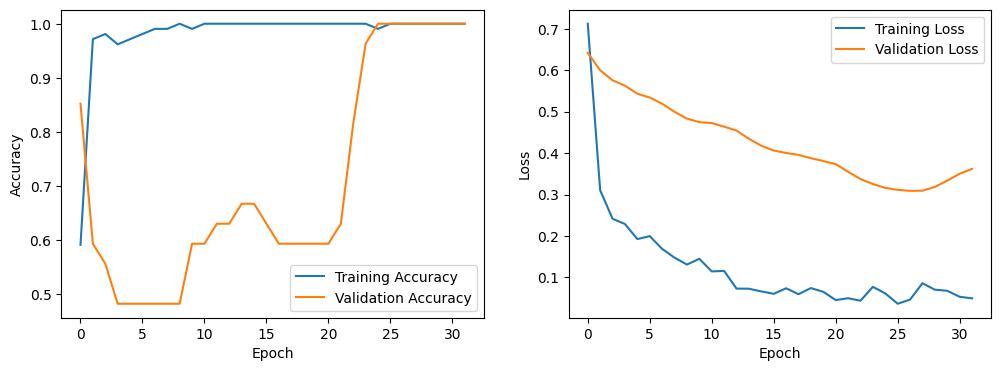

1/1 [==============================] - 0s 139ms/step


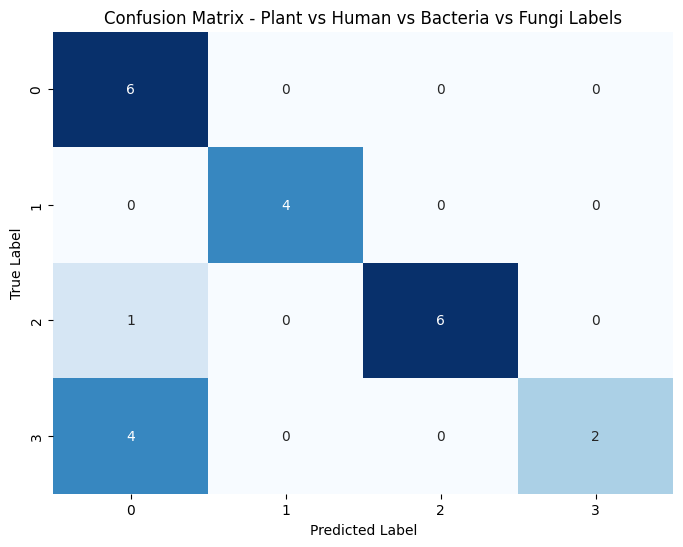

              precision    recall  f1-score   support

    bacteria       0.55      1.00      0.71         6
       fungi       1.00      1.00      1.00         4
       human       1.00      0.86      0.92         7
       plant       1.00      0.33      0.50         6

    accuracy                           0.78        23
   macro avg       0.89      0.80      0.78        23
weighted avg       0.88      0.78      0.77        23

      Label  Precision  F1 Score       AUC       pAUC
0  bacteria   0.545455  0.705882  0.960784  24.500000
1     fungi   1.000000  1.000000  1.000000  25.500000
2     human   1.000000  0.923077  0.982143  25.044643
3     plant   1.000000  0.500000  0.960784  24.500000


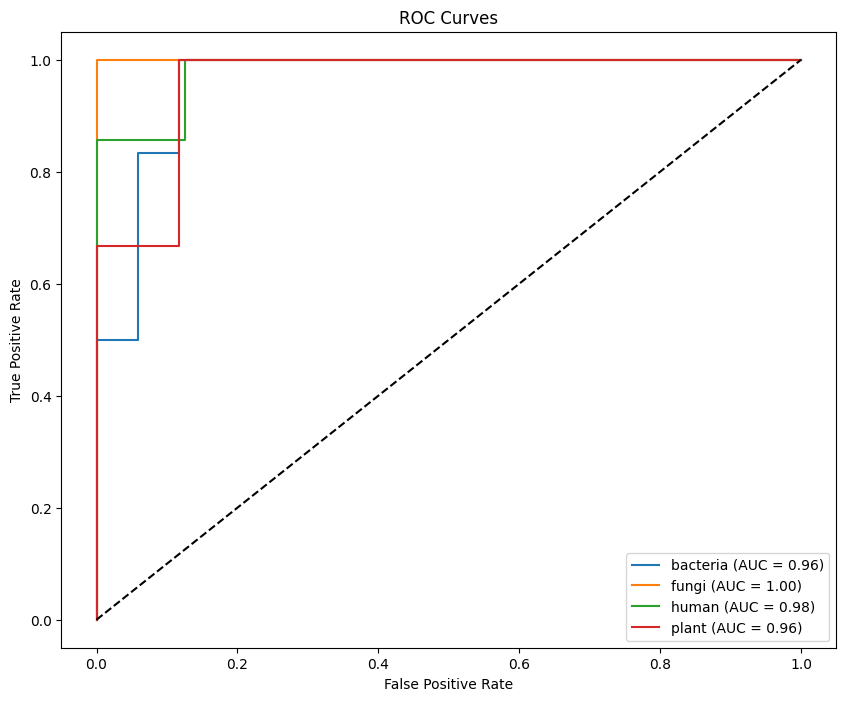

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for each category
plant_paths = [
    '/content/plants_2746287159.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2746290249.fasta',
    '/content/plants_2746290337.fasta',
    '/content/plants_2746386208.fasta',
    '/content/plants_2746386210.fasta'
]

human_paths = [
    '/content/humans_1779351163.fasta',  # Example file paths, adjust according to your actual file names
    '/content/humans_2303923203.fasta',
    '/content/humans_2744499437.fasta',
    '/content/humans_2744499658.fasta',
    '/content/humans_2746299143.fasta'
]

bacteria_paths = [
    '/content/bacteria_2746390579.fasta',
    '/content/bacteria_2746390585.fasta', # Added a comma here
    '/content/bacteria_2746390595.fasta',
    '/content/bacteria_2746390558.fasta',
    '/content/bacteria_2746390560.fasta'
]

fungi_paths = [
    '/content/fungi_2746299064.fasta',
    '/content/fungi_2746299065.fasta',
    '/content/fungi_2746299066.fasta',
    '/content/fungi_2746299067.fasta',
    '/content/fungi_2746388330.fasta'# Example file paths, adjust according to your actual file names
]


# Load sequences from all FASTA files
def load_all_sequences(paths):
    sequences = []
    for path in paths:
        sequences.extend(load_fasta(path))
    return sequences

plant_sequences = load_all_sequences(plant_paths)
human_sequences = load_all_sequences(human_paths)
bacteria_sequences = load_all_sequences(bacteria_paths)
fungi_sequences = load_all_sequences(fungi_paths)

# Define sample sizes (nucleotides)
total_sample_size = 100000
segment_length = 1000

# Sample sequences from each category
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size // 4)
sampled_human_sequences = sample_sequences(human_sequences, segment_length, total_sample_size // 4)
sampled_bacteria_sequences = sample_sequences(bacteria_sequences, segment_length, total_sample_size // 4)
sampled_fungi_sequences = sample_sequences(fungi_sequences, segment_length, total_sample_size // 4)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': (sampled_plant_sequences +
                 sampled_human_sequences +
                 sampled_bacteria_sequences +
                 sampled_fungi_sequences),
    'label': (['plant'] * len(sampled_plant_sequences) +
              ['human'] * len(sampled_human_sequences) +
              ['bacteria'] * len(sampled_bacteria_sequences) +
              ['fungi'] * len(sampled_fungi_sequences))
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 1024), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 64, 512), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate_2', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(best_params['units_2'], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate_2']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Final Model Accuracy: {accuracy * 100:.2f}%')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Plant vs Human vs Bacteria vs Fungi Labels')
plt.show()

report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(report)

def calculate_performance_metrics(y_test, y_pred, labels):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1) # Calculate recall here
    f1_score = 2 * precision * recall / (precision + recall)
    auc = roc_auc_score(y_test, y_pred, average=None)
    pauc = auc / (1 - np.min(auc))

    metrics_df = pd.DataFrame({
        'Label': labels,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUC': auc,
        'pAUC': pauc
    })
    return metrics_df, auc

# Calculate performance metrics and store auc
performance_metrics, auc = calculate_performance_metrics(y_test, y_pred, mlb.classes_) # Store the returned auc
print(performance_metrics)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i, label in enumerate(mlb.classes_):
    if len(np.unique(y_test[:, i])) > 1:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc[i]:.2f})') # Now auc is accessible
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Best hyperparameters: {'units': 848, 'dropout_rate': 0.24892414707160282, 'units_2': 334, 'dropout_rate_2': 0.34276859654205954}
Epoch 1/100
4/4 [==============================] - 2s 191ms/step - loss: 0.6670 - accuracy: 0.6000 - val_loss: 0.7081 - val_accuracy: 0.7037
Epoch 2/100
4/4 [==============================] - 0s 98ms/step - loss: 0.2836 - accuracy: 0.9810 - val_loss: 0.6921 - val_accuracy: 0.7037
Epoch 3/100
4/4 [==============================] - 0s 94ms/step - loss: 0.1916 - accuracy: 0.9905 - val_loss: 0.6646 - val_accuracy: 0.8889
Epoch 4/100
4/4 [==============================] - 0s 100ms/step - loss: 0.1419 - accuracy: 1.0000 - val_loss: 0.6383 - val_accuracy: 0.7037
Epoch 5/100
4/4 [==============================] - 0s 97ms/step - loss: 0.1210 - accuracy: 1.0000 - val_loss: 0.6104 - val_accuracy: 0.8148
Epoch 6/100
4/4 [==============================] - 0s 110ms/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.5813 - val_accuracy: 0.8889
Epoch 7/100
4/4 [===========

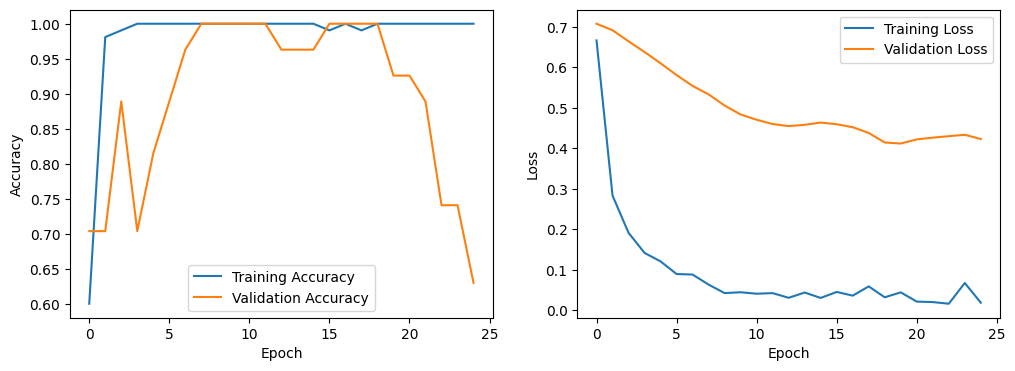

1/1 [==============================] - 0s 139ms/step


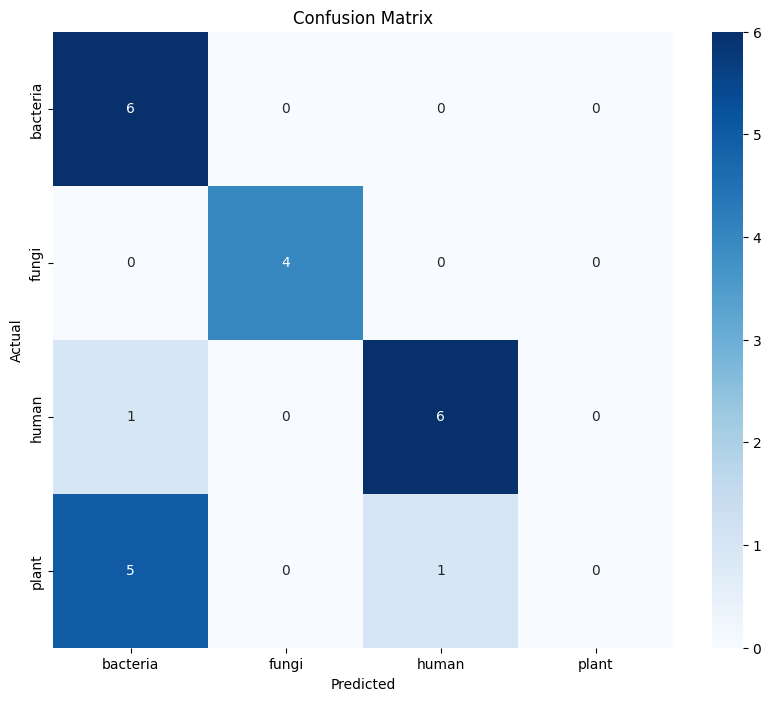

              precision    recall  f1-score   support

    bacteria       0.50      1.00      0.67         6
       fungi       1.00      1.00      1.00         4
       human       0.86      0.86      0.86         7
       plant       0.00      0.00      0.00         6

    accuracy                           0.70        23
   macro avg       0.59      0.71      0.63        23
weighted avg       0.57      0.70      0.61        23

ROC AUC Score: 0.99


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for each category
plant_paths = [
    '/content/plants_2746287159.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2746290249.fasta',
    '/content/plants_2746290337.fasta',
    '/content/plants_2746386208.fasta',
    '/content/plants_2746386210.fasta'
]

human_paths = [
    '/content/humans_1779351163.fasta',  # Example file paths, adjust according to your actual file names
    '/content/humans_2303923203.fasta',
    '/content/humans_2744499437.fasta',
    '/content/humans_2744499658.fasta',
    '/content/humans_2746299143.fasta'
]

bacteria_paths = [
    '/content/bacteria_2746390579.fasta',
    '/content/bacteria_2746390585.fasta', # Added a comma here
    '/content/bacteria_2746390595.fasta',
    '/content/bacteria_2746390558.fasta',
    '/content/bacteria_2746390560.fasta'
]

fungi_paths = [
    '/content/fungi_2746299064.fasta',
    '/content/fungi_2746299065.fasta',
    '/content/fungi_2746299066.fasta',
    '/content/fungi_2746299067.fasta',
    '/content/fungi_2746388330.fasta'# Example file paths, adjust according to your actual file names
]

# Load sequences from all FASTA files
def load_all_sequences(paths):
    sequences = []
    for path in paths:
        sequences.extend(load_fasta(path))
    return sequences

plant_sequences = load_all_sequences(plant_paths)
human_sequences = load_all_sequences(human_paths)
bacteria_sequences = load_all_sequences(bacteria_paths)
fungi_sequences = load_all_sequences(fungi_paths)

# Define sample sizes (nucleotides)
total_sample_size = 100000
segment_length = 1000

# Sample sequences from each category
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size // 4)
sampled_human_sequences = sample_sequences(human_sequences, segment_length, total_sample_size // 4)
sampled_bacteria_sequences = sample_sequences(bacteria_sequences, segment_length, total_sample_size // 4)
sampled_fungi_sequences = sample_sequences(fungi_sequences, segment_length, total_sample_size // 4)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': (sampled_plant_sequences +
                 sampled_human_sequences +
                 sampled_bacteria_sequences +
                 sampled_fungi_sequences),
    'label': (['plant'] * len(sampled_plant_sequences) +
              ['human'] * len(sampled_human_sequences) +
              ['bacteria'] * len(sampled_bacteria_sequences) +
              ['fungi'] * len(sampled_fungi_sequences))
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 1024), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 64, 512), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate_2', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(best_params['units_2'], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate_2']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Final Model Accuracy: {accuracy * 100:.2f}%')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
cr = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(cr)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.2f}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Best hyperparameters: {'units': 346, 'dropout_rate': 0.4287737450666449, 'units_2': 226, 'dropout_rate_2': 0.24974262868902553}
Epoch 1/50
12/12 [==============================] - 2s 55ms/step - loss: 0.4425 - accuracy: 0.8170 - val_loss: 0.6250 - val_accuracy: 0.2211
Epoch 2/50
12/12 [==============================] - 0s 30ms/step - loss: 0.2099 - accuracy: 0.9390 - val_loss: 0.6318 - val_accuracy: 0.2947
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 0.1166 - accuracy: 0.9867 - val_loss: 0.6411 - val_accuracy: 0.1789
Epoch 4/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0997 - accuracy: 0.9788 - val_loss: 0.6310 - val_accuracy: 0.3158
Epoch 5/50
12/12 [==============================] - 1s 60ms/step - loss: 0.0688 - accuracy: 0.9920 - val_loss: 0.6168 - val_accuracy: 0.3474
Epoch 6/50
12/12 [==============================] - 1s 58ms/step - loss: 0.0651 - accuracy: 0.9920 - val_loss: 0.6052 - val_accuracy: 0.4842
Epoch 7/50
12/12 [========

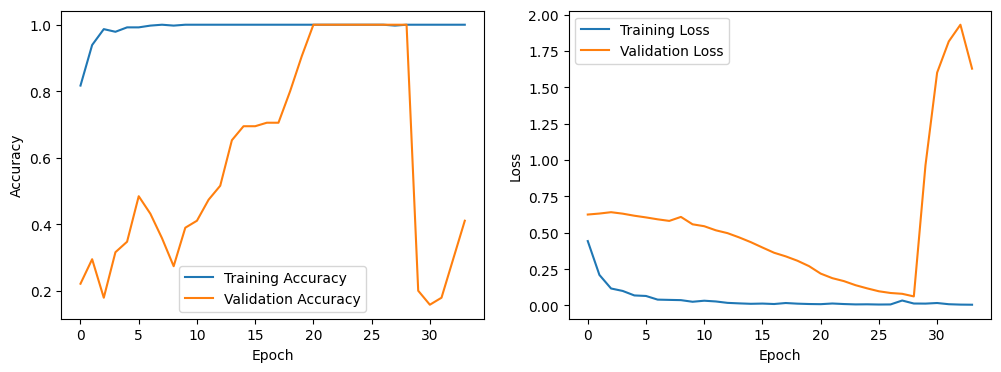

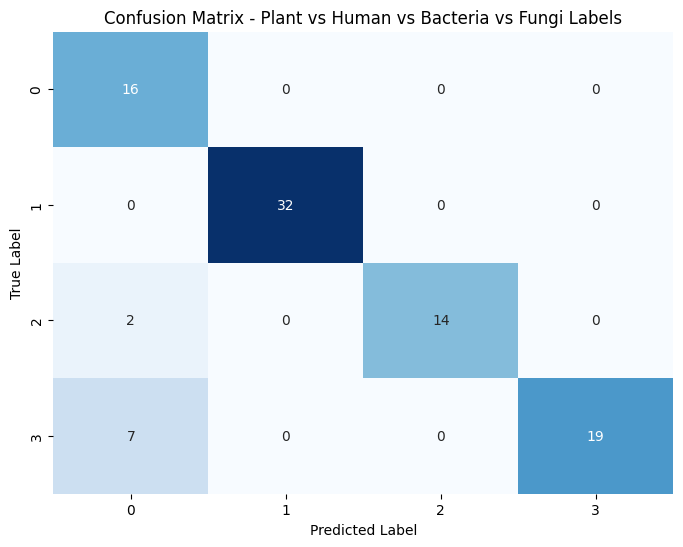

              precision    recall  f1-score   support

    bacteria       0.64      1.00      0.78        16
       fungi       1.00      1.00      1.00        32
       human       1.00      0.88      0.93        16
       plant       1.00      0.73      0.84        26

    accuracy                           0.90        90
   macro avg       0.91      0.90      0.89        90
weighted avg       0.94      0.90      0.90        90

      Label  Precision  F1 Score       AUC       pAUC
0  bacteria       0.64  0.780488  1.000000  64.000000
1     fungi       1.00  1.000000  1.000000  64.000000
2     human       1.00  0.933333  0.999155  63.945946
3     plant       1.00  0.844444  0.984375  63.000000


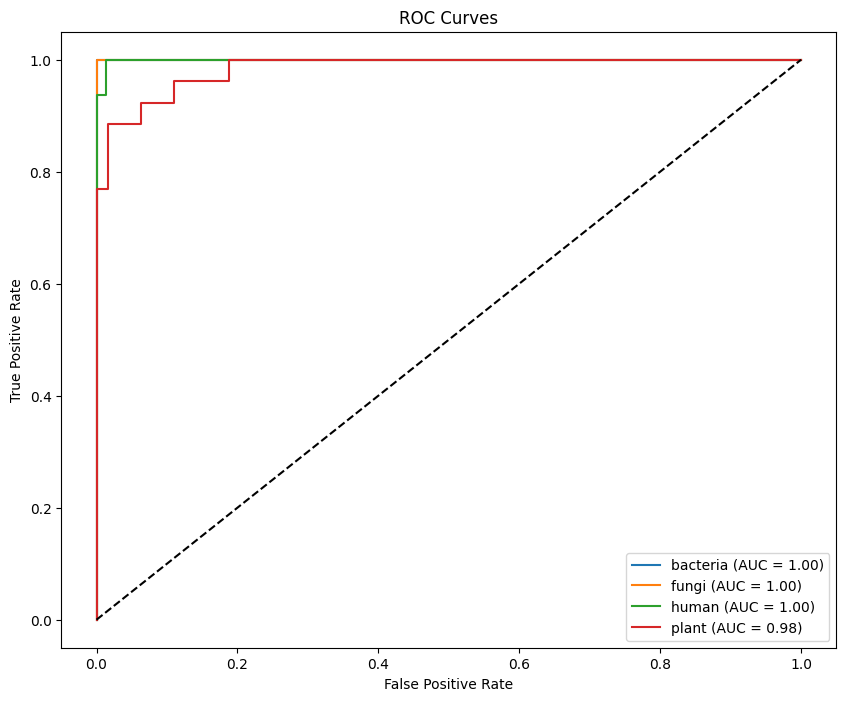

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA filew
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for each category
plant_paths = [
    '/content/plants_2746287159.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2746290249.fasta',
    '/content/plants_2746290337.fasta',
    '/content/plants_2746386208.fasta',
    '/content/plants_2746386210.fasta'
]

human_paths = [
    '/content/humans_1779351163.fasta',  # Example file paths, adjust according to your actual file names
    '/content/humans_2303923203.fasta',
    '/content/humans_2744499437.fasta',
    '/content/humans_2744499658.fasta',
    '/content/humans_2746299143.fasta'
]

bacteria_paths = [
    '/content/bacteria_2746390579.fasta',
    '/content/bacteria_2746390585.fasta', # Added a comma here
    '/content/bacteria_2746390595.fasta',
    '/content/bacteria_2746390558.fasta',
    '/content/bacteria_2746390560.fasta'
]

fungi_paths = [
    '/content/fungi_2746299064.fasta',
    '/content/fungi_2746299065.fasta',
    '/content/fungi_2746299066.fasta',
    '/content/fungi_2746299067.fasta',
    '/content/fungi_2746388330.fasta' # Example file paths, adjust according to your actual file names
]

# Load sequences from all FASTA files
def load_all_sequences(paths):
    sequences = []
    for path in paths:
        sequences.extend(load_fasta(path))
    return sequences

plant_sequences = load_all_sequences(plant_paths)
human_sequences = load_all_sequences(human_paths)
bacteria_sequences = load_all_sequences(bacteria_paths)
fungi_sequences = load_all_sequences(fungi_paths)

# Define sample sizes (nucleotides)
total_sample_size = 400000
segment_length = 1000

# Sample sequences from each category
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size // 4)
sampled_human_sequences = sample_sequences(human_sequences, segment_length, total_sample_size // 4)
sampled_bacteria_sequences = sample_sequences(bacteria_sequences, segment_length, total_sample_size // 4)
sampled_fungi_sequences = sample_sequences(fungi_sequences, segment_length, total_sample_size // 4)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': (sampled_plant_sequences +
                 sampled_human_sequences +
                 sampled_bacteria_sequences +
                 sampled_fungi_sequences),
    'label': (['plant'] * len(sampled_plant_sequences) +
              ['human'] * len(sampled_human_sequences) +
              ['bacteria'] * len(sampled_bacteria_sequences) +
              ['fungi'] * len(sampled_fungi_sequences))
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 1024), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 64, 512), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate_2', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters with more trials
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=7200)  # Stop after 2 hours or 200 trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(best_params['units_2'], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate_2']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the final model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = model.evaluate(X_test, y_test)[1]
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Final Model Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display Confusion Matrix and Classification Report
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Plant vs Human vs Bacteria vs Fungi Labels')
plt.show()

report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1), target_names=mlb.classes_)
print(report)

def calculate_performance_metrics(y_test, y_pred, labels):
    accuracy = np.mean(np.equal(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1_score = 2 * precision * recall / (precision + recall)
    auc = roc_auc_score(y_test, y_pred, average=None)
    pauc = auc / (1 - np.min(auc))

    metrics_df = pd.DataFrame({
        'Label': labels,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUC': auc,
        'pAUC': pauc
    })
    return metrics_df, auc

performance_metrics, auc = calculate_performance_metrics(y_test, y_pred, mlb.classes_)
print(performance_metrics)

plt.figure(figsize=(10, 8))
for i, label in enumerate(mlb.classes_):
    if len(np.unique(y_test[:, i])) > 1:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Best hyperparameters: {'units': 166, 'dropout_rate': 0.2502946088582902, 'units_2': 287, 'dropout_rate_2': 0.2870888434056754}
Epoch 1/50
12/12 [==============================] - 3s 69ms/step - loss: 0.4001 - accuracy: 0.8211 - val_loss: 0.6401 - val_accuracy: 0.8333
Epoch 2/50
12/12 [==============================] - 0s 41ms/step - loss: 0.1777 - accuracy: 0.9658 - val_loss: 0.6037 - val_accuracy: 0.8542
Epoch 3/50
12/12 [==============================] - 0s 36ms/step - loss: 0.1156 - accuracy: 0.9816 - val_loss: 0.6051 - val_accuracy: 0.4062
Epoch 4/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0642 - accuracy: 0.9947 - val_loss: 0.6059 - val_accuracy: 0.1667
Epoch 5/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0467 - accuracy: 0.9974 - val_loss: 0.5866 - val_accuracy: 0.1667
Epoch 6/50
12/12 [==============================] - 0s 18ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.5950 - val_accuracy: 0.1354
Epoch 7/50
12/12 [=========

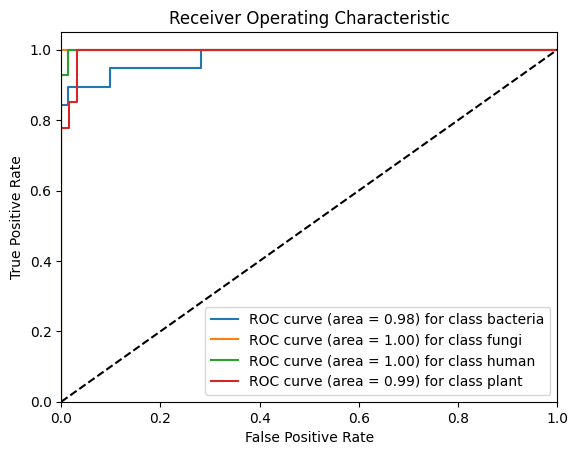

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load sequences from the given FASTA file
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Sample sequences from the provided data
def sample_sequences(sequences, segment_length, total_sample_size):
    sampled_sequences = []
    current_length = 0
    while current_length < total_sample_size:
        seq = random.choice(sequences)
        if len(seq) > segment_length:
            start = random.randint(0, len(seq) - segment_length)
            sampled_segment = seq[start:start + segment_length]
        else:
            sampled_segment = seq
        sampled_sequences.append(sampled_segment)
        current_length += len(sampled_segment)
    return sampled_sequences

# Function to get BERT embeddings for a sequence
def get_bert_embeddings(sequence):
    inputs = tokenizer(sequence, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.numpy().mean(axis=1)

# Paths to the downloaded FASTA files for each category
plant_paths = [
    '/content/plants_2746287159.fasta',  # Example file paths, adjust according to your actual file names
    '/content/plants_2746290249.fasta',
    '/content/plants_2746290337.fasta',
    '/content/plants_2746386208.fasta',
    '/content/plants_2746386210.fasta'
]

human_paths = [
    '/content/humans_1779351163.fasta',  # Example file paths, adjust according to your actual file names
    '/content/humans_2303923203.fasta',
    '/content/humans_2744499437.fasta',
    '/content/humans_2744499658.fasta',
    '/content/humans_2746299143.fasta'
]

bacteria_paths = [
    '/content/bacteria_2746390579.fasta',
    '/content/bacteria_2746390585.fasta', # Added a comma here
    '/content/bacteria_2746390595.fasta',
    '/content/bacteria_2746390558.fasta',
    '/content/bacteria_2746390560.fasta'
]

fungi_paths = [
    '/content/fungi_2746299064.fasta',
    '/content/fungi_2746299065.fasta',
    '/content/fungi_2746299066.fasta',
    '/content/fungi_2746299067.fasta',
    '/content/fungi_2746388330.fasta' # Example file paths, adjust according to your actual file names
]

# Load sequences from all FASTA files
def load_all_sequences(paths):
    sequences = []
    for path in paths:
        sequences.extend(load_fasta(path))
    return sequences

plant_sequences = load_all_sequences(plant_paths)
human_sequences = load_all_sequences(human_paths)
bacteria_sequences = load_all_sequences(bacteria_paths)
fungi_sequences = load_all_sequences(fungi_paths)

# Define sample sizes (nucleotides)
total_sample_size = 400000
segment_length = 1000

# Sample sequences from each category
sampled_plant_sequences = sample_sequences(plant_sequences, segment_length, total_sample_size // 4)
sampled_human_sequences = sample_sequences(human_sequences, segment_length, total_sample_size // 4)
sampled_bacteria_sequences = sample_sequences(bacteria_sequences, segment_length, total_sample_size // 4)
sampled_fungi_sequences = sample_sequences(fungi_sequences, segment_length, total_sample_size // 4)

# Create a DataFrame with sequences and host labels
data = pd.DataFrame({
    'sequence': (sampled_plant_sequences +
                 sampled_human_sequences +
                 sampled_bacteria_sequences +
                 sampled_fungi_sequences),
    'label': (['plant'] * len(sampled_plant_sequences) +
              ['human'] * len(sampled_human_sequences) +
              ['bacteria'] * len(sampled_bacteria_sequences) +
              ['fungi'] * len(sampled_fungi_sequences))
})

# Apply BERT embeddings
data['bert_embeddings'] = data['sequence'].apply(get_bert_embeddings)

# Convert list of embeddings to numpy array
data['bert_embeddings'] = data['bert_embeddings'].apply(lambda x: x[0])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['sequence']).toarray()

# Label Encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'].apply(lambda x: [x]))

# Combine BERT embeddings and TF-IDF features
X = np.hstack((np.array(data['bert_embeddings'].tolist()), X_tfidf))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Define an objective function for Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 128, 1024), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 64, 512), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_rate_2', 0.2, 0.5)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy

# Optimize hyperparameters with early stopping when the desired accuracy is achieved
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=7200)  # Stop after 2 hours or 200 trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units'], activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(best_params['units_2'], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_rate_2']))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the final model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = model.evaluate(X_test, y_test)[1]
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))
class_report = classification_report(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {mlb.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install biopython
